# Streambed seepage model of river at Oneto-Denier
We can apply TPROGs realizations to look at the expected variability in seepage and hyporheic zone residence times. This hyporheic zone residence time modeling could be completed on the local scale or regionally with a focus on the stream channel. Alternatively, the gages at McConnell, LWC and TWC could be used for regional seepage loss estimates, and again their is that satellite drying data.

## Model set up
Initial set up was a year long flow test with the primary boundary condition the SFR package and the GHB included to allow lateral groundwater outflow which is expected as the water entering the perched aquifers may transfer horizontally. Added evapotranspiration with EVT to allow dry season perched aquifer usage. Recharge was added then removed because it caused too much of a jump in levels. Added lake package to represent floodplain recharge in the 2D floodplain.

In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
import shapefile
import geopandas as gpd
from osgeo import gdal
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
reload(flopy)

<module 'flopy' from 'C:\\Users\\ajcalder\\anaconda3\\envs\\geo_env\\Lib\\site-packages\\flopy\\__init__.py'>

# Time discretization
Streambed stage data was collected from December 2019 to December 2021 and successfully captured the first winter flows for both WY2020 and WY2021.

In [4]:
no_ss = False

In [5]:
# Oneto-Denier is about 2012-2019
# Transient -> might want to think about making SP1 steady
end_date = pd.to_datetime('2018-09-30')
# end_date = '2018-01-02'
strt_date = pd.to_datetime('2017-10-01')

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = [1/86400] + np.ones(nper-1).tolist()
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
# when 1 day period have 6 stps, else 1 step
nstp = np.where(np.asarray(perlen)==1, 6, 1)

In [6]:
# adjusters for boundary condition input
if no_ss == True:
    time_tr0 = 0  
    nper_tr = nper 
else:
    time_tr0 = 1
    nper_tr = nper-1
print('NPER ', nper, 'NPER_TR ',nper_tr)

NPER  366 NPER_TR  365


In [7]:
def gdf_bnds(gdf, ax, buf=1):
    gdf_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [gdf.unary_union.buffer(buf)], crs=gdf.crs)
    minx, miny, maxx, maxy = gdf_bnd.bounds.values[0]
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    return(gdf_bnd)



# Grid discretization
The stream stage sensors are installed roughly every 500m in the stream channel, a discretization of 100m is the minimum in the transverse direction of the stream channel or else the stream will fill more space than just one model cell.

In [8]:
delr = 100
delc = 100
rotation=52.9

# model will only be in upper 0-70 ft of the domain, most likely only 0-30ft
unsat_thick = 20 # 20 meter depth roughly, original
unsat_thick = 40 # updated to enable inclusion of deeper ag pumping, and depth of Oneto-Ag
thick = 4
upscale = 8 # from usual 0.5m
nlay = int(unsat_thick/thick)

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [9]:
# load parent model grid
parent_grid = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
nrow_p = int(parent_grid.row.max())
ncol_p = int(parent_grid.column.max())

# Choose location to subset grid

In [156]:
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes']

rm_t[['top_screen','bot_screen']] = rm_t['Screened Interval (ft)'].str.split('-',n=2, expand=True).astype(float)
# calculate elevation from screened interval depth
rm_t['top_screen_m'] = rm_t['MPE (meters)'] - rm_t.top_screen*0.3048
rm_t['bot_screen_m'] = rm_t['MPE (meters)'] - rm_t.bot_screen*0.3048




C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [278]:
# join monitoring extent with parent grid
rm_p_grid = gpd.sjoin(rm_t, parent_grid)
# add 1000 m outward to limit bounary effects
beg_row, beg_col = rm_p_grid.min()[['row','column']] - int(1000/delr)
end_row, end_col = rm_p_grid.max()[['row','column']] + int(1000/delr)


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_10244\1174948741.py:4: FutureWarning: The default value of numeric_only in GeoDataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  beg_row, beg_col = rm_p_grid.min()[['row','column']] - int(1000/delr)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_10244\1174948741.py:5: FutureWarning: The default value of numeric_only in GeoDataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  end_row, end_col = rm_p_grid.max()[['row','column']] + int(1000/delr)


In [12]:

beg_lay = 0
end_lay = 1

child_grid = parent_grid.loc[(parent_grid.row>=beg_row)&(parent_grid.row<end_row)]
child_grid = child_grid.loc[(child_grid.column>=beg_col)&(child_grid.column<end_col)]

child_grid = child_grid.rename({'node':'p_node','row':'p_row','column':'p_column'},axis=1)

In [13]:
child_grid['id'] = 0
m_domain = child_grid.dissolve('id')

<AxesSubplot: >

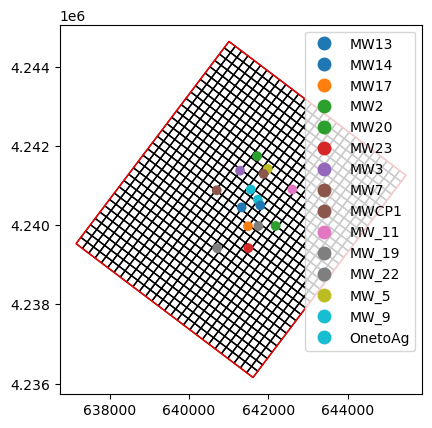

In [14]:
fig,ax=plt.subplots()
# child_extent.plot(ax=ax,color="None")
child_grid.plot(ax=ax, color="None")
m_domain.plot(color="none",edgecolor='red',ax=ax)
rm_t.plot('Sensor',legend=True,ax=ax)

In [15]:
# scale the nuber of rows/cols by change in dimensions
ncol = int(200/delr)*(child_grid.p_column.max() - child_grid.p_column.min()) + 1
nrow = int(200/delc)*(child_grid.p_row.max() - child_grid.p_row.min()) + 1

In [16]:
coords = list(m_domain.geometry.values[0].exterior.coords)
xul = np.min(coords)
yul = coords[np.where(coords==xul)[0][0]][1]

In [17]:
loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
model_nam = 'inset_oneto_denier'

model_ws = loadpth+ model_nam


In [18]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf-owhm', 
                          version = 'mfnwt', model_ws=model_ws)

#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [19]:
mg = m.modelgrid
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(641534.168551493, 4236215.995862045) (637147.4569429542, 4239533.639794644) (640947.6672657495, 4244558.418546243) (645334.3788742883, 4241240.774613644)


In [20]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_nam,'rm_only_grid.shp')

m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

wrote C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel\DIS_data/streambed_seepage/grid\inset_oneto_denier\rm_only_grid.shp


In [21]:
# find matching based on current grid
grid_match = gpd.sjoin(child_grid, grid_p, predicate = 'intersects', how = 'left')
# grid_match.row = grid_match.row.astype(int)
# grid_match.column = grid_match.column.astype(int)

Top of child grid needs to coincide with the top of the parent grid if vertical grid refinement is applied
It would be interesting to look at including the transfer of flow between the parent and child model as it is not currently implemented in MODFLOW. Need to create relation between parent and child grid row, column numbers

In [22]:

dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')

dem_data = np.zeros((nrow,ncol))
dem_data[grid_match.row-1, grid_match.column-1] = dem_data_p[grid_match.p_row-1, grid_match.p_column-1]


<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_10244\1074893619.py:1: DeprecationWarning: invalid escape sequence '\D'
  dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [23]:
# model top is the same as the regional model
m.dis.top = np.copy(dem_data)
botm = np.zeros(m.dis.botm.shape)
botm[0,:] = dem_data -  thick
# model bottom is the same as TPROGs bottoms
for k in np.arange(1, nlay):
    botm[k,:] = botm[k-1,:] - thick
    
m.dis.botm = botm

In [24]:
# list(grid_p.unary_union.exterior.coords)
# bounding box of model grid
xmin,ymin,xmax,ymax = grid_p.unary_union.bounds

# corners of model grid
# xmin, ymin = grid_p.geometry.bounds.min()[['minx','miny']]
# xmax, ymax = grid_p.geometry.bounds.max()[['maxx','maxy']]

# LPF

In [25]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    print('exists')
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
    
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

exists


In [26]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc

from importlib import reload
# importlib.reload
reload(tc)

<module 'tprogs_cleaning' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/tprogs_utilities\\tprogs_cleaning.py'>

In [27]:
tprogs_info = [80, -80, 320]

#  one based is  min:1, 90:mean, max:34
t=89 #0, 33,89
tprogs_line = np.loadtxt(tprogs_files[t])
# filter elevation by regional model
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, dem_data_p, tprogs_info)
# subset masked data to local model
masked_tprogs_local = np.zeros((tprogs_info[2], nrow, ncol))
masked_tprogs_local[:, grid_match.row-1, grid_match.column-1] = masked_tprogs[:,grid_match.p_row-1, grid_match.p_column-1]

# K, Sy, Ss= tc.int_to_param(masked_tprogs_local, params)
K, Sy, Ss,porosity = tc.int_to_param(masked_tprogs_local, params, porosity=True)

# save tprogs facies array as input data for use during calibration
# tprogs_dim = masked_tprogs.shape
# np.savetxt(model_ws+'/input_data/tprogs_facies_array.tsv', np.reshape(masked_tprogs, (tprogs_dim[0]*nrow,ncol)), delimiter='\t')
# masked_tprogs = np.reshape(np.loadtxt(model_ws+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))


In [28]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)
n = np.zeros(botm.shape)

In [29]:
top = np.copy(m.dis.top.array)
bot1 = np.copy(botm[-1,:,:])
# tprogs_info = ()
from scipy.stats import hmean, gmean

# I need to verify if a flattening layer is needed (e.g., variable thickness to maintain TPROGs connectivity)
# pull out the TPROGS data for the corresponding depths
K_c = tc.get_tprogs_for_elev(K, top, bot1,tprogs_info)
Ss_c = tc.get_tprogs_for_elev(Ss, top, bot1,tprogs_info)
Sy_c = tc.get_tprogs_for_elev(Sy, top, bot1,tprogs_info)
n_c = tc.get_tprogs_for_elev(porosity, top, bot1,tprogs_info)

# upscale as preset
for k in np.arange(0,nlay):
    hk[k,:] = np.mean(K_c[upscale*k:upscale*(k+1)], axis=0)
    vka[k,:] = hmean(K_c[upscale*k:upscale*(k+1)], axis=0)
    ss[k,:] = np.mean(Ss_c[upscale*k:upscale*(k+1)], axis=0)
    sy[k,:] = np.mean(Sy_c[upscale*k:upscale*(k+1)], axis=0)
    n[k,:] = np.mean(n_c[upscale*k:upscale*(k+1)], axis=0)

np.savetxt(model_ws+'/porosity_arr.tsv', np.reshape(n, (nlay*nrow,ncol)),delimiter='\t')

In [30]:
# check proportions of hydrofacies in TPROGs realization
tprogs_hist = np.histogram(masked_tprogs, [0,1.1,2.1,3.1,4.1])[0]
tprogs_hist = tprogs_hist/np.sum(tprogs_hist)

# scale vertical conductivity with a vertical anisotropy factor based
# on quantiles in the upscaled tprogs data
for n, p in enumerate(np.arange(1,5)):
    vka[vka >np.quantile(vka, (1-tprogs_hist[n]))] /= params.vani[p]

In [31]:
tprogs_hist

array([0.05799038, 0.19671352, 0.15515291, 0.59014319])

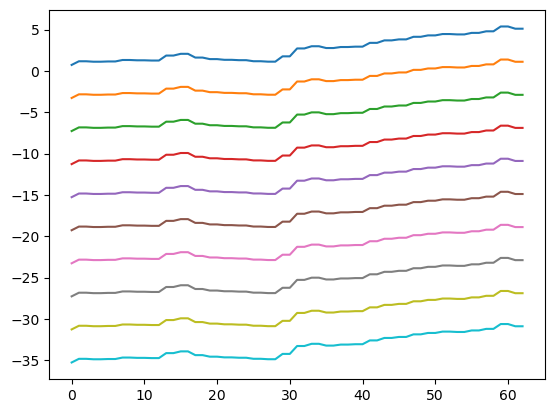

In [32]:
plt.plot(np.transpose(botm[:,int(nrow/2),:]))

In [33]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# try making first 5 layers convertible/ unconfined, 
num_unconf = 5
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = vka, 
                               sy=sy, ss=ss,
                            laytyp=laytyp, laywet = 0, ipakcb=55) # laywet must be 0 for UPW

# gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, 
# #                                ss = storativity, storagecoefficient=True, #storativity
#                                ss=ss, 
#                                laytyp=laytyp, laywet = laywet, ipakcb=55)

In [34]:
# gel.write_file()

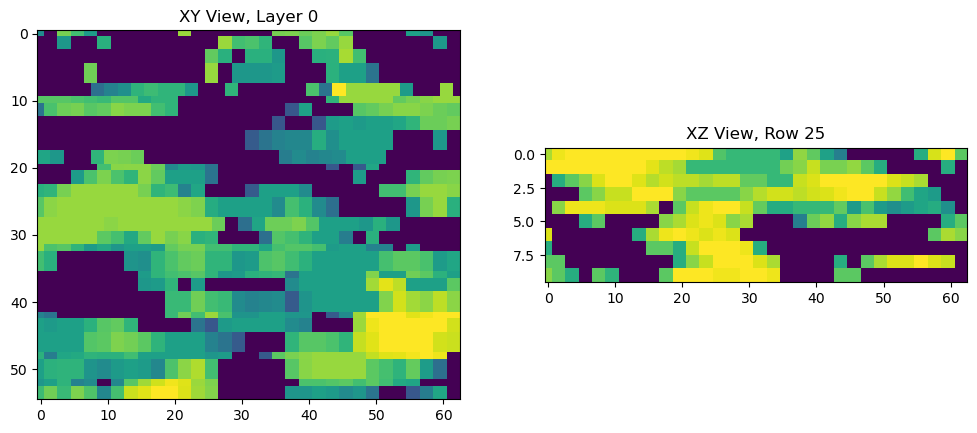

In [35]:
fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].set_title('XY View, Layer 0')
ax[0].imshow(gel.hk.array[0,:,:], norm = mpl.colors.LogNorm())
ax[1].set_title('XZ View, Row 25')
ax[1].imshow(gel.hk.array[:,25,:], norm = mpl.colors.LogNorm())
ax[1].set_aspect(2)

# SFR/LAKE data

In [36]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
# ifp = gpd.read_file(join(lak_shp,'inner_floodplain_domain/inner_floodplain_domain.shp' )).to_crs('epsg:32610')
# lfp = gpd.read_file(join(lak_shp,'lower_floodplain_approximate_area/lower_floodplain_approximate_area.shp' )).to_crs('epsg:32610')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')

fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',op='within')

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [37]:
ETc = np.zeros((nper_tr,nrow_p,ncol_p))
agETc = np.zeros((nper_tr,nrow_p,ncol_p))
rain = np.zeros((nper_tr,nrow_p,ncol_p))
non_dev_rain = np.zeros((nper_tr,nrow_p,ncol_p))
ag_rch = np.zeros((nper_tr,nrow_p,ncol_p))

ETc_count = 0
for y in np.arange(strt_date.year, end_date.year+1):
    # set start and end date for range for the year to be iterated over
    yr_strt = pd.to_datetime(str(y)+'-01-01')
    yr_end = pd.to_datetime(str(y)+'-12-31')
    # get the length of the date range needed for that year
    yearlen = len(pd.date_range(yr_strt, yr_end))
    if yr_strt < strt_date:
        yr_strt = strt_date
    if yr_end > end_date:
        yr_end = end_date
        
    # read in text file of all of the ETc data for each year in array format    
    ET_year = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(y)+'.tsv', delimiter = '\t')
    rain_year = np.loadtxt(gwfm_dir+'/UZF_data/Rain_all_txt_arrays/Rain_array_'+str(y)+'.tsv', delimiter = '\t')
    all_ag_arr = np.loadtxt( gwfm_dir+'/WEL_data/simple_landuse_arrays/ag_land_'+str(y)+'.tsv',  delimiter='\t')
    dev_arr = np.loadtxt( gwfm_dir+'/WEL_data/simple_landuse_arrays/developed_land_'+str(y)+'.tsv',  delimiter='\t')
    non_dev_arr = ~dev_arr.astype(bool) # flip array to have non-developed land array for recharge estimates
    # estimate floodplain and Ag recharge
    natl_flood_y = np.loadtxt(gwfm_dir+'/WEL_data/simple_landuse_arrays/natl_flood_land_'+str(y)+'.tsv', delimiter='\t')
    ag_flood_arr = np.loadtxt(gwfm_dir+'/WEL_data/simple_landuse_arrays/ag_flood_land_'+str(y)+'.tsv', delimiter='\t')
    # aggregate floodplain array over years
    natl_flood_arr = np.where(natl_flood_y>0,1,0)
#     ag_flood_arr = np.where(ag_flood_y>0,1,0)
    
    # correct the shape of the text file from 2D to 3D
    revertETc = np.reshape(ET_year, (yearlen, nrow_p, ncol_p))
    revertrain = np.reshape(rain_year, (yearlen, nrow_p, ncol_p))
    # filter the 3D array based on the desired date range
    filtered_date_ETc = revertETc[yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
    filtered_date_rain = revertrain[yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
    # get the length of the date range needed for that year
    yr_len = len(pd.date_range(yr_strt, yr_end))
    # add the data to the ETc array for the whole model time period
    ETc[ETc_count:ETc_count+yr_len,:,:] = filtered_date_ETc
    agETc[ETc_count:ETc_count+yr_len,:,:] = filtered_date_ETc*all_ag_arr
    rain[ETc_count:ETc_count+yr_len,:,:] = filtered_date_rain
    non_dev_rain[ETc_count:ETc_count+yr_len,:,:] = filtered_date_rain*non_dev_arr
    # extra recharge for alfalfa irrigation to offset lowered water levels
    ag_rch[ETc_count:ETc_count+yr_len,:,:] = filtered_date_ETc*ag_flood_arr
    ETc_count += yr_len

In [38]:
# subset data to local model
et_local = np.zeros((nper_tr, nrow, ncol))
et_local[:, grid_match.row-1, grid_match.column-1] = ETc[:,grid_match.p_row-1, grid_match.p_column-1]

# subset data to local model
finf_local = np.zeros((nper_tr, nrow, ncol))
finf_local[:, grid_match.row-1, grid_match.column-1] = rain[:,grid_match.p_row-1, grid_match.p_column-1]


# subset data to local model
ag_local = np.zeros((nper_tr, nrow, ncol))
ag_local[:, grid_match.row-1, grid_match.column-1] = agETc[:,grid_match.p_row-1, grid_match.p_column-1]



# SFR

## XS pre-processing

In [39]:
# cross sections sampled using NHD lines at regular 100 m intervals (not aligned with any grid)
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')

# find XS that are in the modeled domain by thalweg point
thalweg = xs_all[xs_all.dist_from_right_m==100]
thalweg = gpd.overlay(thalweg, grid_p)
# thalweg = thalweg.cx[xmin:xmax, ymin:ymax]

# pivot based on XS number and save only elevation in z_m
xs_all_df = pd.read_csv(dat_dir+'Elevation_by_XS_number_meters.csv',index_col=0)
xs_all_df = xs_all_df.dropna(axis=0,how='any')

# filter XS by those that are within the domain bounds
xs_all = xs_all[xs_all.xs_num.isin(thalweg.xs_num.values)]
xs_all_df = xs_all_df.loc[:, thalweg.xs_num.astype(str)]

# renumber XS
thalweg.xs_num = np.arange(0,thalweg.shape[0])
xs_all.xs_num = np.repeat(thalweg.xs_num.values,xs_all.dist_from_right_m.max()+1)
xs_all_df.columns = thalweg.xs_num

In [40]:
from shapely.geometry import LineString
i = 0
# Number of cross sections
numxs = int(len(xs_all_df.columns))
# i is the cross-section number
lp = pd.DataFrame(np.linspace(1,int(numxs),int(numxs)))
lp['geometry'] = LineString([(0,0),(0,1)])

for i in np.arange(0,numxs): #numxs
    # Number of points in each cross section
    numl = np.sum(pd.notna(xs_all_df.iloc[:,i]))
    # Create empty array to fill with coordinates
    lines = np.zeros((numl,2))
    # j is the number of points in each individual cross-section
    lm = LineString(list(zip(xs_all_df.index.values, xs_all_df.iloc[:,i].values)))
    tol = 0.6
    deltol = 0.1
    count = 0
    lms = LineString(lm).simplify(tolerance = tol)
    while len(list(lms.coords))>8:
        if len(list(lms.coords)) <5:
            deltol = 0.001
        temp = lms
        lms = LineString(lm).simplify(tolerance = tol)
        tol += deltol
#         if count drops below 8 then reduce deltol
#         if len(list(lms.coords)) <6:
#             lms = temp
#             tol -= deltol
#             deltol *= 0.5     
        count += 1

    print(i,':',len(list(lms.coords)),end = ' - ') #count, 
    lp.geometry.iloc[int(i)] = LineString(lms)
    
# some segments will never be able to match the ideal number of points despite very fine loops

0 : 7 - 1 : 7 - 2 : 6 - 3 : 7 - 4 : 7 - 5 : 8 - 6 : 8 - 7 : 8 - 8 : 8 - 9 : 8 - 10 : 8 - 11 : 8 - 12 : 8 - 13 : 8 - 14 : 8 - 15 : 7 - 16 : 6 - 

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_10244\2110285611.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp.geometry.iloc[int(i)] = LineString(lms)


17 : 8 - 18 : 8 - 19 : 8 - 20 : 8 - 21 : 8 - 22 : 7 - 23 : 8 - 24 : 8 - 25 : 8 - 26 : 8 - 27 : 8 - 28 : 8 - 29 : 7 - 30 : 8 - 31 : 7 - 32 : 8 - 33 : 6 - 34 : 8 - 35 : 8 - 36 : 7 - 37 : 7 - 38 : 7 - 39 : 7 - 40 : 8 - 41 : 8 - 42 : 8 - 43 : 7 - 44 : 8 - 45 : 8 - 46 : 7 - 47 : 8 - 48 : 5 - 49 : 7 - 50 : 7 - 51 : 7 - 52 : 8 - 53 : 6 - 54 : 8 - 55 : 8 - 56 : 8 - 57 : 8 - 58 : 7 - 59 : 8 - 60 : 8 - 61 : 8 - 62 : 8 - 63 : 7 - 64 : 6 - 65 : 8 - 66 : 7 - 67 : 5 - 68 : 7 - 69 : 7 - 70 : 7 - 71 : 7 - 72 : 8 - 73 : 8 - 74 : 8 - 75 : 6 - 76 : 8 - 

In [41]:
# create summary of XS for creating SFR inputs
xs_wide = xs_all.pivot_table(index='dist_from_right_m',values='z_m',columns='xs_num')
thalweg_pts = xs_wide.idxmin().values.astype(int)
xs_mins = xs_all.set_index(['dist_from_right_m','xs_num']).loc[list(zip(thalweg_pts, xs_wide.columns))]
XSg_in = xs_mins.reset_index('dist_from_right_m')

# join segment data to grid
XSg_in = gpd.sjoin(XSg_in, grid_p, op='within', how='inner')
# if multiple points in one cell take first, not a big deal since there are points every 100 m
XSg_in = XSg_in.reset_index().groupby(['row','column'], as_index=False).first()
XSg_in = XSg_in.sort_values('xs_num')
# create segment numbers, starting at 1 to allow for first segment defined by michigan bar criteria
XSg_in['iseg'] = np.arange(1, XSg_in.shape[0]+1) # add the segment that corresponds to each cross section
XSg_in.crs = xs_all.crs


C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [42]:
# filter cross sections to those that matched in the grid
xs_all = xs_all[xs_all.xs_num.isin(XSg_in.xs_num)]
xs_all_df = xs_all_df.loc[:, XSg_in.xs_num]

In [43]:
XS8pt = pd.DataFrame(np.zeros((numxs*8, 3)), columns=['xs_num','dist_from_right_m','z_m'])
XS8pt.xs_num = np.repeat(np.arange(0,numxs), 8)

# lpg = gpd.GeoDataFrame(lp[:])
xscoords = np.zeros((8, numxs))
filler = np.zeros(2)
filler[:] = np.nan
for i in np.arange(0, numxs):
    coordtemp = np.array(list(lp.geometry.iloc[i].coords))
    coordtemp = coordtemp[~np.isnan(coordtemp[:,0])]
    # if missing points add to make 8
    while len(coordtemp) < 8:
        endfill = np.copy(coordtemp[-1,:]) # take last and add new point
        endfill[0] += 1 # offset with different x
        coordtemp = np.vstack((coordtemp, endfill))
    # reset distance from right to start at 0
    coordtemp[:,0] -= coordtemp[0,0]
    XS8pt.loc[XS8pt.xs_num==i,['dist_from_right_m','z_m']] = coordtemp   

# filter for XS in final segments
XS8pt = XS8pt.loc[XS8pt.xs_num.isin(XSg_in.xs_num)]
XS8pt.to_csv(proj_dir + '8pointXS_'+model_nam+'.csv', index = False)
XS8pt = XS8pt.set_index('xs_num')


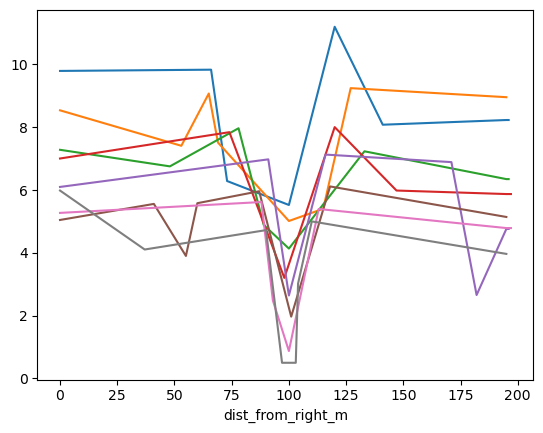

In [44]:
# even plotting all XS they show the same triangular shape
fig,ax = plt.subplots()
for n in XS8pt.index.unique()[::10]:
    XS8pt.loc[n].plot(x='dist_from_right_m',y='z_m', ax=ax,legend=False)

In [45]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k +1
    return(elev_lay.astype(int))
                

In [46]:
XSg_z = XSg_in.copy().set_index('iseg')

# find minimum value in XS related to thalweg
XSg_z['z_m_min'] = xs_all.dissolve('xs_num','min').z_m
#roling mean of 6 window centered removes any negative slope
XSg_z['z_m_min_cln'] = XSg_z.z_m_min.rolling(6,center=False).mean()

# calculate slope and fill NAs, fill slope with nearby
z_cln_diff = XSg_z.z_m_min_cln.diff().bfill()
XSg_z['slope'] = z_cln_diff.abs()/delr
# correct slope less than 1E-4
XSg_z.loc[XSg_z.slope<1E-4,'slope'] = 1E-4

# fix str bot so all is downward sloping
for i in XSg_z.index[-2::-1]:
# fill NAs due to rolling mean, with backward filling
    if np.isnan(XSg_z.loc[i,'z_m_min_cln']):
        XSg_z.loc[i,'z_m_min_cln'] = XSg_z.loc[i+1,'z_m_min_cln'] + XSg_z.loc[i,'slope']*delr

for i in XSg_z.index[:-1]:
    if XSg_z.loc[i+1,'z_m_min_cln'] >= XSg_z.loc[i,'z_m_min_cln']:
        XSg_z.loc[i+1,'z_m_min_cln'] = XSg_z.loc[i,'z_m_min_cln'] - XSg_z.loc[i,'slope']*delr


# XSg_z.slope.plot(secondary_y = True)

In [47]:
# identify XS to be copied for diversion reaches
fp_grid_xs = fp_grid[['Logger Location','geometry']].sjoin_nearest(XSg_z.reset_index().drop(columns=['index_right']), how='inner')
# od_breach is the sensor location where the breach was made in the levees for flow to leave the river
od_breach = fp_grid_xs[fp_grid_xs['Logger Location']=='OD_Excavation']
od_swale = fp_grid_xs[fp_grid_xs['Logger Location']=='SwaleBreach_1']


In [48]:
# add reaches for diversion
# is it worth redefining the row,column? Could cause issues with disconnected cells
XSg = pd.concat((XSg_z.reset_index(), od_breach,od_swale)) #, od_swale
#, od_swale don't need extra seg for the outflow
XSg = XSg[~((XSg.xs_num==od_swale.xs_num.values[0])&(XSg['Logger Location'].isna()))]
# redefine xs_num/iseg
XSg  = XSg.sort_values('xs_num')
XSg['iseg'] = np.arange(1,XSg.shape[0]+1)
XSg = XSg.set_index('iseg')

In [49]:
# fill upstream with parameters from sensors
# pcols= ['strhc1', 'strthick', 'thts','thti','eps','uhc','thtr', 'roughch','roughbk']
# XSg[pcols] = XSg[pcols].bfill()

XSg.to_csv(join(model_ws,'04_XSg_filled.csv'))

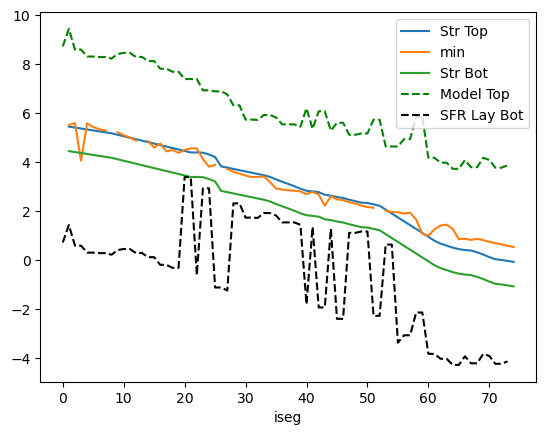

In [50]:
# plot, large spike in top elevation causes discontinuity
sfr_rows = (XSg.row.values-1).astype(int)
sfr_cols = (XSg.column.values-1).astype(int)
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# owhm default raises layer to topmost active which is 1
strthick = 1
strtop = XSg.z_m_min_cln.values - strthick
# sfr_lay = get_layer_from_elev(strtop, botm[:, sfr_rows, sfr_cols], m.dis.nlay)
# find layers where str top is above
sfr_lay = pd.DataFrame(np.transpose(np.where(strtop>m.dis.botm.array[:, sfr_rows, sfr_cols])), columns=['layer','iseg'])
# find topmost layer with minimum
sfr_lay = sfr_lay.groupby('iseg').min()['layer'].values

(XSg.z_m_min_cln).plot(label='Str Top')
XSg.z_m_min.plot(label='min')
(XSg.z_m_min_cln-strthick).plot(label='Str Bot')

plt.plot(m.dis.top.array[ sfr_rows, sfr_cols], label='Model Top', ls='--',color='green')
# plt.plot(m.dis.botm.array[0, sfr_rows, sfr_cols], label='Lay 1 Bottom', ls='--',color='brown')
# plt.plot(m.dis.botm.array[sfr_lay-1, sfr_rows, sfr_cols], label='SFR Lay Top', ls='--',color='black')
plt.plot(m.dis.botm.array[sfr_lay, sfr_rows, sfr_cols], label='SFR Lay Bot', ls='--',color='black')

plt.legend()

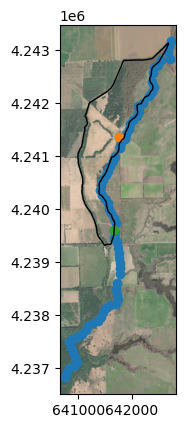

In [52]:

fig,ax=plt.subplots()
# gdf_bnds(breach_grid,ax=ax, buf=200)
XSg.plot(ax=ax)
od_breach.plot(ax=ax)
od_swale.plot(ax=ax)
# grid_p.plot(ax=ax,color='none')

# fp_logger[fp_logger['Logger Type']=='Breach'].plot('Logger Location',ax=ax, legend=True, legend_kwds={'loc':(1,0.3)})
lak_extent.plot(ax=ax, color='none')
ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

## SFR input

In [53]:
# There is one reach for each cell that a river crosses
NSTRM = -len(XSg)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days, 60 for minutes
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 5
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day = 0.001 cfs
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*CONST

sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [54]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [55]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = XSg.node
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = XSg.index
sfr.reach_data.ireach = 1 
sfr.reach_data.rchlen = 100 #xs_sfr.length_m.values
sfr.reach_data.strtop = XSg.z_m_min_cln.values
sfr.reach_data.slope = XSg.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = strthick
sfr.reach_data.strhc1 = vka[sfr.reach_data.k, sfr.reach_data.i, sfr.reach_data.j] #/10

# UZF parameters
# sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
# sfr.reach_data.thti = sfr.reach_data.thts
# sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
# sfr.reach_data.uhc = vka[0,sfr.reach_data.i, sfr.reach_data.j]


In [56]:
sfr.write_file()
# sfr.check()

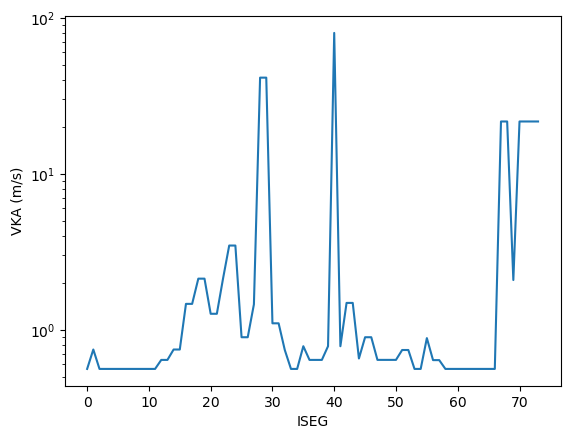

In [57]:

plt.plot(sfr.reach_data.strhc1)
plt.xlabel('ISEG')
plt.ylabel('VKA (m/s)')
plt.yscale('log')

In [58]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


In [59]:
sfr_seg = sfr.segment_data[0].copy()

In [60]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
# sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion

# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [61]:
# diversion segment
od_div = XSg[XSg['Logger Location']=='OD_Excavation']
# downstream channel segment
od_sfr = XSg[XSg.xs_num==od_div.xs_num.values[0]]
od_sfr = od_sfr[od_sfr['Logger Location'].isna()]
# upstream segment to diversion and channel
up_div = XSg[XSg.xs_num == od_div.xs_num.values[0]-1]


# outflow from floodplain
od_out = XSg[XSg['Logger Location']=='SwaleBreach_1']
od_sfr_out = XSg[XSg.xs_num==od_out.xs_num.values[0]]

In [62]:
div_seg = od_div.index[0]
chan_seg = od_sfr.index[0]
up_seg = up_div.index[0]

In [63]:
# adjust segments to include floodplain connection
# for previous work I used a different XS input to add these side segments, but on a large scale I can probably
# use the existing reaches allowing for a gap (100m)
sfr_seg.outseg[sfr_seg.nseg==up_seg] = chan_seg # the river should flow to the channel segment first
 # there will be a diversion from the river to the dam above 27 cms, of which 20% will be returned to the side channel
sfr_seg.iupseg[sfr_seg.nseg==div_seg] = up_seg
sfr_seg.iprior[sfr_seg.nseg==div_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
sfr_seg.flow[sfr_seg.nseg==div_seg] = 27*86400 # 27 cms is floodplain threshold per Whipple in the Cosumnes
sfr_seg.outseg[sfr_seg.nseg==div_seg] = -1 #outflow from segment is OD floodplain

# adjust for flow from diversion segment back to  channel
sfr_seg.iupseg[sfr_seg.nseg==chan_seg] = div_seg
sfr_seg.iprior[sfr_seg.nseg==chan_seg] = -2 # the flow diverted is a % of the total flow in the channel
sfr_seg.flow[sfr_seg.nseg==chan_seg] = 0.5 # the side channel is about 1/4 the size so 20% of flow should run through

# divert flow from lake back into the segment after the dam
sfr_seg.iupseg[sfr_seg.nseg==od_sfr_out.index[0]] = -1 # no need to change iprior because diversion is based on lake stage
    

In [64]:
sfr.segment_data[0] = sfr_seg

In [65]:
# Change column name to float type for easier referencing in iteration
# XS8pt.columns = XS8pt.columns.astype('float')
# XS8pt
# must start at 0 if only at teichert
xsnum = 1

# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(xsnum,len(XSg)+xsnum)}  }


for k in XSg.xs_num:
        XCPT = XS8pt.loc[k].dist_from_right_m.values # old XS8pt[k].index
        ZCPT = XS8pt.loc[k].z_m.values # old XS8pt[k].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [66]:
sfr.check()

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conductances...
1 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
0	26	42	21	1	100.0	1.0	1.266494870185852
0	26	42	22	1	100.0	1.0	1.266494870185852

Checking for streambed tops of less than -10...
isfropt setting of 1,2 or 3 requires strtop information!


Checking for streambed tops of greater than 15000...
isfropt setting of 1,2 or 3 requires strtop information!


Checking segment_data for downstream rises in streambed elevation...
Seg

In [67]:
# FLOWTAB = mb4rl.discharge_va.values
# DPTHTAB = mb4rl.gage_height_va.values
# WDTHTAB = mb4rl.chan_width.values
# sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [68]:
sfr.write_file()

## SFR Tab File

In [69]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# # np.arange(0,len(flow_cmd))

time_flow = np.vstack((np.arange(time_tr0,len(inflow.flow_cmd)+time_tr0),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
if no_ss == False:
    time_flow = np.row_stack(([0, inflow.flow_cmd.median()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

Text(0, 0.5, 'Flow ($m^3/d$)')

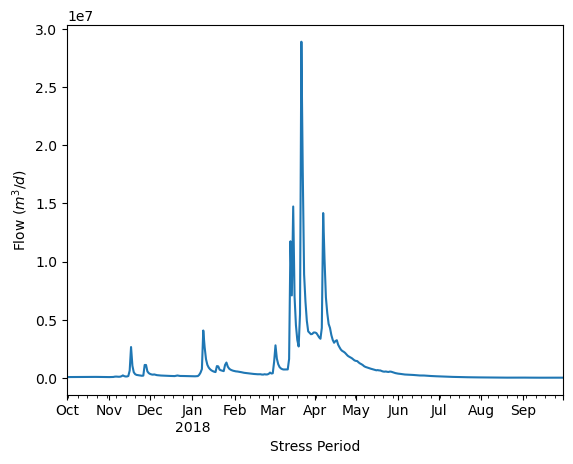

In [70]:
# inflow.plot(y='flow_cfs')
inflow.plot(y='flow_cmd',legend=False)
# plt.plot(time_flow[:,0], time_flow[:,1])
plt.xlabel('Stress Period')
plt.ylabel('Flow ($m^3/d$)')

In [71]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

# LAK Package

<AxesSubplot: >

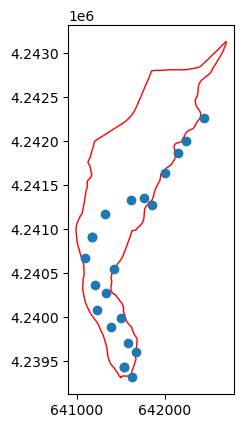

In [72]:
fig,ax=plt.subplots()
# ifp.plot(ax=ax, color='none')
lak_extent.plot(ax=ax,color='none',edgecolor='red')
# lfp.plot(ax=ax, color='none')

fp_logger.plot(ax=ax)

In [73]:
# create clipped raster of just lake area
dem_dir = join(gwfm_dir,'DEM_data')
raster_name = dem_dir+'/mwt_peri_2_3.tif/mwt_peri_2_3_clipped.tif'
import rasterio.mask
with rasterio.open(raster_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, lak_extent.geometry.values, crop=True)
    out_meta = src.meta
# write output
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(join(lak_shp,"floodplain_crop.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

In [74]:
lak_buf = lak_extent.copy()
lak_buf.geometry = lak_buf.buffer(100)
# grid_sfr.drop('index_right',axis=1)
# gpd.sjoin(grid_c_nums, lak_buf, how='left',op='contains').plot()
lak_grid = gpd.overlay(grid_p, lak_extent, how='intersection')
# get cells with more than 1/3 of Blodgett Dam "lake extent"
# lak_grid = lak_grid.loc[lak_grid.geometry.area > delr[lak_grid.row]*delr[lak_grid.column]/3]

# Set empty array of zeros for nonlake cells
lakarr = np.zeros((nlay, nrow,ncol))
# Each lake is given a different integer, and needs to be specified depending on the layer
lakarr[0,(lak_grid.row.values-1).astype(int),(lak_grid.column.values-1).astype(int)] = 1

# set Ksat same as vertical conductivity, 
lkbd_thick = 2
lkbd_K = vka[0,:,:]
lkbd_K[lakarr[0]==0] = 0 # where lake cells don't exist set K as 0
# leakance is K/lakebed thickness
bdlknc = lkbd_K/lkbd_thick

lakeRst = rasterio.open(join(lak_shp,"floodplain_crop.tif"))
lakeBottom = lakeRst.read(1)
noDataValue = np.copy(lakeBottom[0,0])
#replace value for np.nan
lakeBottom[lakeBottom==noDataValue]= np.nan

# get raster minimum and maximum 
minElev = np.nanmin(lakeBottom)
maxElev = np.nanmax(lakeBottom)
print('Min bottom elevation %.2f m., max bottom elevation %.2f m.'%(minElev,maxElev))

# steps for calculation
nSteps = 151
# lake bottom elevation intervals
elevSteps = np.round(np.linspace(minElev,maxElev,nSteps),2)

# definition of volume function
def calculateVol_A(elevStep,elevDem,lakeRst):
    tempDem = elevStep - elevDem[elevDem<elevStep]
    tempArea = len(tempDem)*lakeRst.res[0]*0.3048*lakeRst.res[1]*0.3048
    tempVol = tempDem.sum()*lakeRst.res[0]*0.3048*lakeRst.res[1]*0.3048
    return(tempVol, tempArea)
# calculate volumes, areas for each elevation
volArray = [0]
saArray = [0]
for elev in elevSteps[1:]:
    tempVol,tempArea = calculateVol_A(elev,lakeBottom,lakeRst)
    volArray.append(tempVol)
    saArray.append(tempArea)


# print("Lake bottom elevations %s"%elevSteps)
# volArrayMCM = [round(i/1000000,2) for i in volArray]
# print("Lake volume in million of cubic meters %s"%volArrayMCM)

Min bottom elevation 3.03 m., max bottom elevation 11.57 m.


In [75]:
# get average et lake in floodplain for lake package
et_lake = et_local*lakarr[0]
et_lake = et_lake.sum(axis=(1,2))/(lakarr[0].sum())
# et_lake

In [76]:
# Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
# A separate file is required for each lake. 
# initial lake stage should be dry (below lake bottom)
# stages = minElev - lkbd_thick - 0.1 # causes lake to remain dry for entire simulation
stages = minElev +0.01

# (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
# so double array is necessary
stage_range = [[minElev, maxElev]]

# lake stage (elevation), volume, and area (3 numbers per line)
lak_depth = elevSteps - elevSteps[0]
bathtxt = np.column_stack((elevSteps, volArray, saArray))

# np.savetxt(m.model_ws+'/MF.bath', bathtxt, delimiter = '\t')


## Need to specify flux data
# Dict of lists keyed by stress period. The list for each stress period is a list of lists,
# with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
flux_data = { (j) : {0: [0, et_lake[j-1], 0, 0] } for j in np.arange(time_tr0,nper)}

flux_data[0] = {0:[0, et_lake.mean(),0,0]}

# flux_data = {0:{0:[0,0,0,0]}}

# 1 1000 1E-5 0.02 - taken from mt shasta
# filler value for bdlknc until soil map data is loaded by uzf
lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
                               stage_range=stage_range, flux_data = flux_data,
                               theta = 1, nssitr = 1000, sscncr = 1E-5, surfdepth = 0.02, # take from Shasta model
                               tabdata= True, tab_files='MF.bath', tab_units=[57],ipakcb=55)

# the lak package doesn't specify the tab file unit number when the files are written
# example:      110.0     100.0     170.0   22   Item 3:  STAGES,SSMN,SSMX,IUNITLAKTAB

lak.options = ['TABLEINPUT']

# # need to reset tabdata as True before writing output for LAK
lak.tabdata = True

In [77]:
lak.write_file()

In [78]:
# numgage is total number of gages
# gage_data (list, or array), includes 2 to 3 entries (LAKE UNIT (OUTTYPE)) for each LAK entry
#  4 entries (GAGESEG< GAGERCH, UNIT, OUTTYPE) for each SFR package entry
# gage_data = rm_xs[['iseg','reach','unit', 'outtype']].values.tolist()
gage_file = ['MF.gage']
gag_out_files = ('MF_gage_' + XSg.index.astype(str) +'.go').values.tolist()

lak_gage_data = [[-1, -37, 1]]
gage_file = ['MF.gage']
gag_out_files = ['MF_lak.go']
gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=lak_gage_data, 
                                filenames =gage_file+gag_out_files)


# BAS6

In [79]:
ibound = np.ones((nlay,nrow,ncol))
# to maintain gw flow gradient that mimics ground surface slope shanafield used a CHD at up and down stream
# ibound[:,:,0] = -1
# ibound[:,:,-1] = -1

#originally started heads 5 m below stream bottom but gw mound started connection in middle reaches
strt = np.zeros(ibound.shape)
strt[:] = m.dis.top.array
# strt = np.reshape(XSg.z_m_min.values, (nrow,ncol)) - 10 # start heads below the stream bottom
#lake cells must be set as inactive

ibound[lakarr>0] = 0

In [80]:
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt, stoper = 2) #

In [81]:
# bas.write_file()

# Evapotranspiration
Groundwater elevations are too high in the steady state of the model before the inclusion of ET and there are large amounts of GDEs that are drawing groundwater from the shallow system. The ET could be estimated with the diurnal fluctuation method by White or through a standard method such as CIMIS data times crop coefficients.  
The previous analysis I did with the White method using diurnal groundwater fluctuations indicated a large gap between GW estimated ET and CIMIS likely because CIMIS ET doesn't directly account for whether the soil has water.  
Research during GSP development indicated a maximum of 30 ft for riparian vegetation like valley oaks, but the USDA/LANDIQ maps aren't specific to crops on the floodplains (gives general term of riparian vegetation or wetland). The NAIP imagery used in the GSP might help identify the zones that should have this used.  
Model will assume no irrigation unless demonstrated as needed because limited amounts of the preserve are irrigated for corn.

In [82]:
uzf_dir = join(gwfm_dir, 'UZF_data')
gde_dir = join(uzf_dir,'shp_GDE_TFT')

glob.glob(join(gde_dir,'SA_subbasin_GDE','*shp'))

if not exists(join(gde_dir,'gde_domain.shp')):
    # large file
    GDE_union = gpd.read_file(join(gde_dir,'SA_subbasin_GDE','GDE_union.shp'))
    # GDE_union = gpd.read_file(join(gde_dir,'SA_subbasin_GDE','NCAG_vegetation.shp'))
    # is it worth differentiating mixed riparian scrub, woodland, forest? for et rates and rooting depths
    GDE_domain = gpd.overlay(GDE_union, m_domain.to_crs(GDE_union.crs))
    # save file
    GDE_domain.to_file(join(gde_dir, 'gde_domain.shp'))
else:
    GDE_domain = gpd.read_file(join(gde_dir, 'gde_domain.shp'))


<AxesSubplot: >

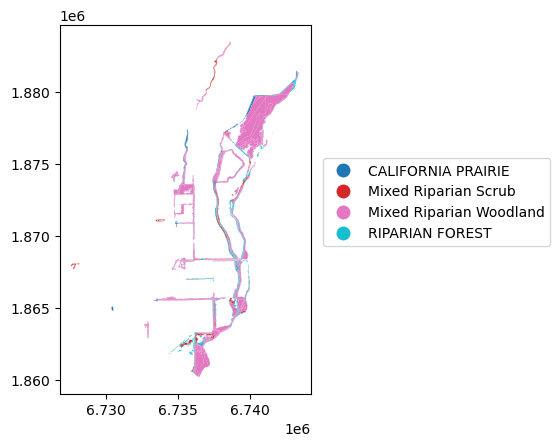

In [83]:
# the visual map combined with field knowledge suggests that it is mapping the location of higher tree density
# that occur along the river channel and near certains roads/drainages
# it's worth identifying these as zones up to 30 ft (9 m) while leaving the rest up to 6 ft (2 m) which is max depth for 
# more field type crops
GDE_domain.plot('Type',legend=True, legend_kwds={'loc':(1.05,0.4)})

In [84]:
if not join(gde_dir,'GDE_cell.shp'):
    # spatial join with grid to identify cells with deeper rooting depth
    GDE_grid = gpd.sjoin(GDE_domain.to_crs(grid_p.crs), grid_p, how='inner', op='intersects')

    GDE_grid['rtg_dp'] = 2 # default rooting depth to 2 meters
    # scrub could be an intermediate??
    GDE_grid.loc[GDE_grid.Type=='Mixed Riparian Scrub','rtg_dp']=4
    # those described as woodland/forest get deeper designation
    GDE_grid.loc[GDE_grid.Type=='Mixed Riparian Woodland','rtg_dp']=10
    GDE_grid.loc[GDE_grid.Type=='RIPARIAN FOREST','rtg_dp']=10

    # slow to compute
    GDE_cell = GDE_grid.dissolve(by='node', aggfunc = 'mean')
    GDE_cell.to_file(join(gde_dir,'GDE_cell.shp'))
else:
    GDE_cell = gpd.read_file(join(gde_dir,'GDE_cell.shp'))

<AxesSubplot: >

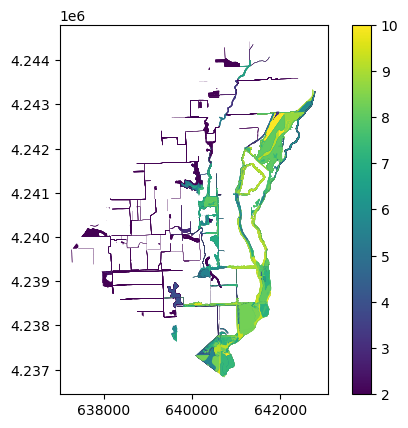

In [85]:
# as expected we see much deeper rooting depth in the main area of the preserve
# the adjustment up to 4 seems appropriate for scrubland
GDE_cell.plot('rtg_dp',legend=True)

In [86]:
# convert rooting depth to array format for modflow input
ext_dp = np.full((nrow,ncol),2)
ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = GDE_cell.rtg_dp

In [87]:
# plt.imshow(et_local.sum(axis=0))
# plt.colorbar()

max_ET = et_local.mean(axis=0).sum()*100*100 # the full water usage from ET could be up to 86,000
max_ET_dp = (et_local.mean(axis=0)*(ext_dp>7)).sum()*100*100 # if only looking at ET deeper than 
print('Max SS ET: %.2f' %max_ET, 'Max SS ET with GW below 7m: %.2f' %max_ET_dp)

Max SS ET: 88258.11 Max SS ET with GW below 7m: 5789.82


In [88]:
# remove evapotranspiration in stream cells
et_local[:, sfr_rows, sfr_cols] = 0
# remove evapotranspiration in stream cells
ag_local[:, sfr_rows, sfr_cols] = 0


# have transient recharge start after the 1st spd
et_spd = { (j): et_local[j-1,:,:] for j in np.arange(time_tr0,nper)}
finf_spd = { (j): finf_local[j-1,:,:] for j in np.arange(time_tr0,nper)}

In [89]:

if no_ss == False:
    finf_spd[0] = finf_local.mean(axis=0)
    et_spd[0] = et_local.mean(axis=0)
    
# still need to consider additional recharge due to flooding

In [90]:
# can use the RCH + EVT packages to almost replace UZF minus the soil budget calculation, but
# at Oneto-Denier much of the interaction is near the water surface so perhaps valid? adjust if too much recharge

# surf : et surface elevation. evtr: maximum ET flux
# exdp: extinction depth. ievt : layer indicator variable
evt = flopy.modflow.ModflowEvt(model=m, nevtop = 3, evtr = et_spd, exdp = ext_dp, ievt = 0, 
                               surf = m.dis.top.array, ipakcb = 55)



In [91]:
# evt.write_file()


In [92]:
# nrchtop : rch to which layer, rech:array of recharge rates
# rch = flopy.modflow.ModflowRch(model=m, nrchop = 3, rech = finf_spd, ipakcb = 55)
# rch.write_file()

In [93]:
# recharge to top active layer (nuztop=3), iuzfopt=0=no rch routing,
# irunflg =0=no runoff routing, ietflg=1=et is active
# uzf = flopy.modflow.ModflowUzf1(model = m, nuztop = 3, iuzfopt=0, irunflg = 0, ietflg = 1,
#                          ipakcb=65)
# # defin the hydrologic inputs
# uzf.finf = finf_spd
# uzf.pet = et_spd
# uzf.extdp = ext_dp
# extwc
# uzf.write_file()
# before adding UZF runs were around 3 minutes

# WEL
Pumping to bring summer levels down.


In [94]:
ET_ag = np.copy(ag_local)
if no_ss ==False:
    ET_ag_SS = np.reshape(ET_ag.mean(axis=0),(1, nrow,ncol))
    ET_ag = np.concatenate((ET_ag_SS, ET_ag), axis=0)
print(ET_ag[0].sum())
# remove pumping where it is considered GDE, reduced SS by almost 1/2 (5.7 to 3.6)
ET_ag[:, (GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = 0
print(ET_ag[0].sum())
# remove pumping where it is known restoration (floodplain), doesn't remove much (3.65 to 3.61)
ET_ag[:, lakarr[0] >0] = 0
print(ET_ag[0].sum())
# since there would likely still be too much pumping maybe it's an issue with pumping next to the boundary and
# some landowners might use surface water supply?

5.709334236712331
3.65848301671233
3.6186987079452066


In [95]:
# plt.imshow(ET_ag[7*30:].sum(axis=0))
# plt.colorbar()
# np.unique(gel.ss.array)*8

In [96]:
# fig, ax = plt.subplots()
# GDE_cell.plot(color='none', ax=ax)
# ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
#                 crs = 'epsg:26910', alpha=0.8)

In [97]:
wells_grid = pd.read_csv(gwfm_dir+'/WEL_data/wells_grid.csv')
wells_grid = gpd.GeoDataFrame(wells_grid, geometry = gpd.points_from_xy(wells_grid.easting, wells_grid.northing),
                              crs='epsg:32610')
# filter to local grid area
wells_grid = wells_grid.drop(columns=['node','row','column']).sjoin(grid_p)

In [98]:
reg_ag_well_depth_arr = np.loadtxt(gwfm_dir+'/WEL_data/ag_well_depth_arr.tsv', delimiter='\t')
ag_well_depth_arr = np.zeros((nrow,ncol))
ag_well_depth_arr[grid_match.row-1, grid_match.column-1] = reg_ag_well_depth_arr[grid_match.p_row-1, grid_match.p_column-1]


In [99]:
ag_screen_botm = np.where(dem_data-ag_well_depth_arr<botm)
ag_screen_botm = np.rot90(ag_screen_botm)
ag_screen_botm = pd.DataFrame(ag_screen_botm, columns=['layer','row','column'])
ag_max_lay = ag_screen_botm.groupby(['row','column']).max()
# any wells below most bottom go in bottom layer
ag_max_lay.layer[ag_max_lay.layer == nlay] = nlay-1

# assume 10% of well is screened? Pauloo? tprogs lay thickness is 4m, so 12ft, not quite enough for typical well?
# if we go two layers we have 8 m which is near the average expected well screen
ag_screen_top = np.where((dem_data-ag_well_depth_arr*0.9)<botm)
ag_screen_top = np.rot90(ag_screen_top)
ag_screen_top = pd.DataFrame(ag_screen_top, columns=['layer','row','column'])
ag_min_lay = ag_screen_top.groupby(['row','column']).max()
ag_min_lay.layer[ag_min_lay.layer == nlay] = nlay-1


In [100]:
# iterate over all row, col and get layers for each well based on "screen" 
ag_well_lay = np.zeros((1,3))
for i,j in zip(ag_min_lay.reset_index().row,ag_min_lay.reset_index().column):
    lays = np.arange(ag_min_lay.layer.loc[i,j],ag_max_lay.layer.loc[i,j]+1)
    ijk = np.rot90(np.vstack((np.tile(i,len(lays)), np.tile(j,len(lays)),lays)))
    ag_well_lay = np.vstack((ag_well_lay,ijk))
# delete filler first row
ag_well_lay = ag_well_lay[1:]
ag_well_lay = pd.DataFrame(ag_well_lay.astype(int), columns=['row','column','layer'])

In [101]:
num_ag_layers = (ag_max_lay - ag_min_lay+1).reset_index()
# divide ET_ag by the number of layers it will go into
ET_ag_layered = np.copy(ET_ag)
ET_ag_layered[:,num_ag_layers.row,num_ag_layers.column] /= num_ag_layers.layer.values
# adjustments to allow connection with rows,cols with pumping
row_col = ag_well_lay.loc[:,['row','column']].rename({'row':'rowi','column':'colj'},axis=1)
ag_well_lay = ag_well_lay.set_index(['row','column'])
ag_well_lay['rowi'] = row_col.rowi.values
ag_well_lay['colj'] = row_col.colj.values

In [102]:
# layer for ETc ag well pumping
# ETc_lay = 1
# create empty dictionary to fill with stress period data
wel_ETc_dict = {}
# end date is not included as a stress period, starting at 1st TR spd (2)
for t in np.arange(0,nper):
    wel_i, wel_j = np.where(ET_ag[t,:,:]>0)
    new_xyz = ag_well_lay.loc[list(zip(wel_i,wel_j))] 
# use new row,cols because there are more layers to use
    wel_ETc = -ET_ag_layered[t,new_xyz.rowi,new_xyz.colj]*delr*delr
    # ['layer','row','column', 'flux'] are necessary for WEL package
    spd_ag = np.stack((new_xyz.layer, new_xyz.rowi, new_xyz.colj,wel_ETc),axis=1)
    # correct by dropping any rows or cols without pumping as some may be added
    spd_ag = spd_ag[spd_ag[:,-1]!=0,:]
    # join pumping from ag with point pumping from domstic/supply wells that are constant
#     spd_all = np.vstack((spd_ag,spd_noag)) 
    spd_all = np.copy(spd_ag)
    wel_ETc_dict[t] = spd_all

In [103]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_ETc_dict,ipakcb=55)

In [104]:
# wel.write_file()

# GHB

We have a fairly shallow groundwater level so the interpolated levels can be inserted here. 

The whole LGR process is beyond the complexity here as we don't need the local model feeding results back to a regional scale, we just need to know the regional model output on a local scale so as a starting point I'm using kriged levels. (There is a way to do this with LGR but would require reworking SFR etc.)

In [105]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [106]:
nrow_r, ncol_r = (100,230)
strtyear = strt_date.year
endyear = end_date.year+1
kriged_fall = np.zeros((int(endyear-strtyear),nrow_r,ncol_r))
kriged_spring = np.zeros((int(endyear-strtyear),nrow_r,ncol_r))

kriged_NW = np.zeros((int(endyear-strtyear)*2,ncol_r))
kriged_SE = np.zeros((int(endyear-strtyear)*2,ncol_r))
# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

t=0
for year in np.arange(strtyear,endyear):
    
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_spring[t,:,:] = df_grid
    
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_fall[t,:,:] = df_grid

    year_to_int[t,0] = t
    year_to_int[t,1] = year
    t+=1
    

In [107]:
# convert from
kriged_fall_c = np.zeros((kriged_fall.shape[0], nrow,ncol))
kriged_fall_c[:, grid_match.row-1,grid_match.column-1] = kriged_fall[:, grid_match.p_row-1,grid_match.p_column-1]

kriged_spring_c = np.zeros((kriged_spring.shape[0], nrow,ncol))
kriged_spring_c[:, grid_match.row-1,grid_match.column-1] = kriged_spring[:, grid_match.p_row-1,grid_match.p_column-1]

In [108]:
## NW is row 0, SE is last row
kriged_NW = np.vstack((kriged_spring_c[:,0,:],kriged_fall_c[:,0,:]))
kriged_SE = np.vstack((kriged_spring_c[:,nrow-1,:],kriged_fall_c[:,nrow-1,:] ))
    

In [109]:
y_num=0

# nwhead_fall = kriged_fall[:,0,:]
# sehead_fall = kriged_fall[:,-1,:]


# Set kriged water table elevations that are above land surface to land surface minus 15 ft (based on historical levels)
# nwhead_fall = np.where(nwhead_fall>dem_data[0,:], dem_data[0,:] - 15*0.3048, nwhead_fall)
# sehead_fall = np.where(sehead_fall>dem_data[-1,:], dem_data[-1,:]- 15*0.3048, sehead_fall)
dem_offset = 15*0.3048
# dem_offset = 0

kriged_NW = np.where(kriged_NW>dem_data[0,:], dem_data[0,:]- dem_offset, kriged_NW)
kriged_SE = np.where(kriged_SE>dem_data[-1,:], dem_data[-1,:]- dem_offset, kriged_SE)

# calculate the average depth to water table for the spring and from 2013-2018 for the northwest and southeast boundary
avg_nw = np.nanmean(kriged_NW,axis=0)
avg_se = np.nanmean(kriged_SE,axis=0)

In [110]:
# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array


In [111]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
#             if botm_slice[k,j] < elev[j]:
#                 elev_lay[j] = k 
    return(elev_lay.astype(int))
                
nw_lay = get_layer_from_elev(avg_nw, botm[:,0,:], m.dis.nlay)
se_lay = get_layer_from_elev(avg_se, botm[:,-1,:], m.dis.nlay)

In [112]:
# ghb_hk_nw = scaling_factors.K_nw
# ghb_hk_se = scaling_factors.K_se

distance = 5000
t0 = time.time()

col_strt=1

ghbnw_spd = pd.DataFrame(np.zeros((np.sum(nlay-nw_lay[col_strt:]),5)))
ghbnw_spd.columns = ['k','i','j','bhead','cond']
# start 1 column in to avoid conflict with delta boundary

# get all of the j,k indices to reduce math done in the for loop
yz = np.zeros((np.sum(nlay-nw_lay[col_strt:]),2)).astype(int)
n=0
for j in np.arange(col_strt,ncol):
    for k in np.arange(nw_lay[j], nlay):
        yz[n,0] = j
        yz[n,1] = k
        n+=1
        
condnw = hk[yz[:,1],0,yz[:,0]]*(top_botm[yz[:,1],0,yz[:,0]]-top_botm[yz[:,1]+1,0,yz[:,0]])*delr/distance
# condnw = ghb_hk_nw*(top_botm[yz[:,1],0,yz[:,0]]-top_botm[yz[:,1]+1,0,yz[:,0]])*delr/distance

ghbnw_spd.cond = condnw
ghbnw_spd.bhead = avg_nw[yz[:,0]]
ghbnw_spd.k = yz[:,1]
ghbnw_spd.j = yz[:,0]
ghbnw_spd.i = 0

ghbse_spd = pd.DataFrame(np.zeros((np.sum(nlay-se_lay[col_strt:]),5)))
ghbse_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
yz = np.zeros((np.sum(nlay-se_lay[col_strt:]),2)).astype(int)
n=0
for j in np.arange(col_strt,ncol):
    for k in np.arange(se_lay[j], nlay):
        yz[n,0] = j
        yz[n,1] = k
        n+=1
condse = hk[yz[:,1],int(nrow-1),yz[:,0]]*(top_botm[yz[:,1],-1,yz[:,0]]-top_botm[yz[:,1]+1,-1,yz[:,0]])*delr/distance
# condse = ghb_hk_se*(top_botm[yz[:,1],-1,yz[:,0]]-top_botm[yz[:,1]+1,-1,yz[:,0]])*delr/distance

ghbse_spd.cond = condse
ghbse_spd.bhead = avg_se[yz[:,0]]
ghbse_spd.k = yz[:,1]
ghbse_spd.j = yz[:,0]
ghbse_spd.i = nrow-1
        
resample_time = time.time() - t0
print("GHB time: {:.3f} sec".format(time.time() - t0))

GHB time: 0.021 sec


In [113]:
distance = 5000
# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
delta_hk = (2E-4) *86400

ghbdelta_spd = pd.DataFrame(np.zeros(((nlay*nrow),5)))
ghbdelta_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
xz = np.zeros((nlay*nrow,2)).astype(int)
n=0
for i in np.arange(0,nrow):
    for k in np.arange(0, nlay):
        xz[n,0] = i
        xz[n,1] = k
        n+=1
cond = delta_hk*(top_botm[xz[:,1],:,0]-top_botm[xz[:,1]+1,:,0])*delr/distance
ghbdelta_spd.cond = cond
ghbdelta_spd.bhead = 0
ghbdelta_spd.k = xz[:,1]
ghbdelta_spd.j = 0
ghbdelta_spd.i = xz[:,0]

In [114]:
# lay, row, col for delta ghb
zxy = ghbdelta_spd.values[:,:3].astype(int)
# drop any delta ghb cells where cell bottom is below sea level
ghbdn_spd =  ghbdelta_spd.values[botm[zxy[:,0],zxy[:,1],zxy[:,2]]<0]
# join dataframes of 3 ghb boundaries together
ghb_spd = np.vstack((ghbdn_spd, ghbse_spd.values, ghbnw_spd.values))


In [115]:

# GHB for east and west model boundaries
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data =  {0: ghb_spd},ipakcb=55)
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [116]:
# flopy writes an error when a GHB cell head is below a cell elevation which is good to consider
# but necessary to allow some outflow
# owhm also warns when this occurs stating it may cause convergence problems
# ghb.write_file()
# ghb.check()

# HOB

In [119]:
hob_dir = join(gwfm_dir,'HOB_data')

In [279]:
# spatial join with child grid
rm_grid = gpd.sjoin(rm_t, grid_p)


In [280]:
# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

avg_screen = rm_grid[['top_screen_m','bot_screen_m']].mean(axis=1).values
rm_grid['lay'] = get_layer_from_elev(avg_screen, m.dis.botm[:,hob_row, hob_col], m.dis.nlay)


In [281]:
# load field data
gwl = pd.read_csv(join(hob_dir,'AllSets.csv'), parse_dates=['dt'], index_col=['dt'], dtype=object)
gwl.index = gwl.index.tz_localize(None)
gwl = gwl.apply(lambda x: pd.to_numeric(x, errors='coerce'))
# filter for wells within the grid
gwl = gwl.loc[:,gwl.columns.isin(rm_t.Sensor.values)]
# filter for dates within the period
gwl = gwl.loc[strt_date:end_date]

# taking daily average only changes maximum/minimum values by 0.01-0.3
# np.max(np.abs(gwl.resample('D').mean().min()- gwl.min())), np.max(np.abs(gwl.resample('D').mean().max()- gwl.max()))
gwl_D = gwl.resample('D').mean()

# long format to prepare for identifier
gwl_long = gwl_D.melt(ignore_index=False, var_name='Well',value_name='obs')
# drop NAs
gwl_long = gwl_long.dropna(subset=['obs'])
# # get spd corresponding to dates
gwl_long['spd'] = (gwl_long.index-strt_date).days.values + time_tr0
# create unique obs name for each obs based on spd
gwl_long['obs_nam'] = gwl_long.Well +'p'+ gwl_long.spd.astype(str).str.zfill(3)

In [289]:
# calculate offset from the centroid
hob_centroids = grid_p.set_index(['row','column']).loc[list(zip(rm_grid.row, rm_grid.column))].geometry.centroid.values
rm_grid['coff'] = hob_centroids.x - rm_grid.geometry.x 
rm_grid['roff'] = hob_centroids.y - rm_grid.geometry.y 


In [290]:
# create a new hob object
obs_data = []
hob_wells = rm_grid.Sensor[rm_grid.Sensor.isin(gwl_long.Well.unique())]
for i, s in enumerate(hob_wells): # for each well location
    # get stress period data and water surface elevation for well
    site = rm_grid.set_index('Sensor').loc[s]
    row = site.row - 1
    col = site.column - 1
    layer = site.lay
    roff = site.roff # row (y), col (x) offset from center of cell
    coff = site.coff
    names = gwl_long[gwl_long.Well==s].obs_nam.tolist()
    obsname = s
        
    tsd = gwl_long[gwl_long.Well==s][['spd','obs']].values
    # need to minus 1 for grid_p which is 1 based
    temp = flopy.modflow.HeadObservation(m, layer=layer, row=row, 
                                                  column=col,
                                                  time_series_data=tsd,
                                                  obsname=obsname, names = names)
    # correct time offset from stress period to be 0
    temp.time_series_data['toffset'] = 0
    obs_data.append(temp)


In [292]:
hob = flopy.modflow.ModflowHob(m, iuhobsv=50, hobdry=-9999., obs_data=obs_data, unitnumber = 39,
                              hobname = 'MF.hob.out')

In [293]:
# hob.write_file()

# Output Control

In [167]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days
spd = {}
# output file for parallel runs when head/cbc is not needed
for j in month_intervals:
    spd[j,0] = ['print budget']
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True, filenames='MF_parallel.oc')
oc.write_file()


# For later model runs when all the data is needed to be saved
spd = {}
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

# Solver

In [168]:
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified')
nwt_dict = nwt.__dict__

# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'/Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'Second'].astype(nwt_ex.loc[v,'nwt_dtype'])
    
# correct fluxtol for model units of m3/day instead of m3/second
nwt_dict['fluxtol'] = 500 
    # update NWT sovler parameters
nwt.__dict__ = nwt_dict

nwt.write_file()

In [169]:
# m.write_name_file()

# Write input

In [221]:
# Writing the MODFLOW data files
# m.write_input()


#